In [1]:
import io
from functools import cache

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from pandas import DataFrame
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
from http import HTTPStatus


@cache
def read_usa_bea(url: str) -> DataFrame:
    """
    Retrieves U.S. Bureau of Economic Analysis DataFrame from URL

    Parameters
    ----------
    url : str

    Returns
    -------
    DataFrame
    ================== =================================
    df.index           Period
    df.iloc[:, 0]      Series IDs
    df.iloc[:, 1]      Values
    ================== =================================
    """
    kwargs = {
        'header': 0,
        'names': ('series_ids', 'period', 'value'),
        'index_col': 1,
        'thousands': ','
    }
    if requests.head(url).status_code == HTTPStatus.OK:
        kwargs['filepath_or_buffer'] = io.BytesIO(requests.get(url).content)
    else:
        kwargs['filepath_or_buffer'] = url.split('/')[-1]
    return pd.read_csv(**kwargs)

In [3]:
def pull_by_series_id(df: DataFrame, series_id: str) -> DataFrame:
    """


    Parameters
    ----------
    df : DataFrame
    ================== =================================
    df.index           Period
    df.iloc[:, 0]      Series IDs
    df.iloc[:, 1]      Values
    ================== =================================
    series_id : str

    Returns
    -------
    DataFrame
    ================== =================================
    df.index           Period
    df.iloc[:, 0]      Series
    ================== =================================
    """
    assert df.shape[1] == 2
    return df[df.iloc[:, 0] == series_id].iloc[:, [1]].rename(
        columns={"value": series_id}
    )

In [4]:
def collect_usa_investment_turnover() -> DataFrame:
    SERIES_IDS = {
        'A006RC': 'https://apps.bea.gov/national/Release/TXT/NipaDataA.txt',
        'A006RD': 'https://apps.bea.gov/national/Release/TXT/NipaDataA.txt',
        'A191RC': 'https://apps.bea.gov/national/Release/TXT/NipaDataA.txt',
        'A191RX': 'https://apps.bea.gov/national/Release/TXT/NipaDataA.txt',
        # =====================================================================
        # Not Used: Fixed Assets: k3n31gd1es00, 1925--2020, Table 4.3. Historical-Cost Net Stock of Private Nonresidential Fixed Assets by Industry Group and Legal Form of Organization
        # =====================================================================
        'k3n31gd1es00': 'https://apps.bea.gov/national/FixedAssets/Release/TXT/FixedAssets.txt',
        # =====================================================================
        # Fixed Assets: kcn31gd1es00, 1925--2020, Table 4.2. Chain-Type Quantity Indexes for Net Stock of Private Nonresidential Fixed Assets by Industry Group and Legal Form of Organization
        # =====================================================================
        'kcn31gd1es00': 'https://apps.bea.gov/national/FixedAssets/Release/TXT/FixedAssets.txt',
    }
    df = pd.concat(
        [
            read_usa_bea(url).pipe(pull_by_series_id, series_id)
            for series_id, url in SERIES_IDS.items()
        ],
        axis=1,
        sort=True
    )
    # =========================================================================
    # Investment, 2012=100
    # =========================================================================
    df['_investment'] = df.loc[:, 'A006RD'].mul(
        df.loc[2012, 'A006RC']).div(100)
    # =========================================================================
    # Capital, 2012=100
    # =========================================================================
    df['_capital'] = df.loc[:, 'kcn31gd1es00'].mul(
        df.loc[2012, 'k3n31gd1es00']).mul(1000).div(100)
    # =========================================================================
    # Capital Retirement Ratio
    # =========================================================================
    df['_ratio_mu'] = df.iloc[:, -
                              2].mul(1).sub(df.iloc[:, -1].shift(-1)).div(df.iloc[:, -1]).add(1)
    return (
        df.loc[:, ['_investment', 'A191RX',
                   '_capital', '_ratio_mu']].dropna(axis=0),
        df.loc[:, ['_ratio_mu']].dropna(axis=0),
    )

In [5]:
def plot_fourier_discrete(df: DataFrame, precision: int = 10) -> None:
    """
    Discrete Fourier Transform based on Simpson's Rule
    ================== =================================
    df.index           Period
    df.iloc[:, 0]      Target Series
    ================== =================================
    """

    _df = df.copy()
    print(_df)

    precision += 1
    _p = np.polyfit(
        _df.index.to_series().astype(int),
        _df.iloc[:, 0].astype(float),
        deg=1
    )
    print(_p)
    _df['period_calibrated'] = _df.index.to_series().sub(
        _df.index[0]).div(_df.shape[0]).mul(2).mul(np.pi).astype(float)
    _df[f'{_df.columns[0]}_line'] = _df.index.to_series().mul(_p[0]).add(_p[1])
    _df[f'{_df.columns[0]}_wave'] = _df.iloc[:, 0].sub(_df.iloc[:, 2])
    # =========================================================================
    # DataFrame for Fourier Coefficients
    # =========================================================================
    _fourier = DataFrame(columns=['cos', 'sin'])
    for _ in range(precision):
        _fourier.loc[_] = [
            _df.iloc[:, 3].mul(np.cos(_df.iloc[:, 1].mul(_))).mul(2).mean(),
            _df.iloc[:, 3].mul(np.sin(_df.iloc[:, 1].mul(_))).mul(2).mean()
        ]
    # =========================================================================
    # First Entry Correction
    # =========================================================================
    _fourier.loc[0, 'cos'] /= 2
    plt.figure()
    plt.title(f'$\\alpha$ for the US, {_df.index[0]}$-${_df.index[-1]}')
    plt.xlabel('Period')
    plt.ylabel('Index')
    plt.scatter(_df.index, _df.iloc[:, 0], label='$\\alpha$')
    _df[f'{_df.columns[0]}_fourier_{0}'] = np.cos(_df.iloc[:, 1].mul(0)).mul(
        _fourier.loc[0, 'cos']).add(np.sin(_df.iloc[:, 1].mul(0)).mul(_fourier.loc[0, 'sin']))
    for _ in range(1, precision):
        _df[f'{_df.columns[0]}_fourier_{_}'] = _df.iloc[:, -1].add(np.cos(_df.iloc[:, 1].mul(_)).mul(
            _fourier.loc[_, 'cos'])).add(np.sin(_df.iloc[:, 1].mul(_)).mul(_fourier.loc[_, 'sin']))
        plt.plot(_df.iloc[:, 2].add(_df.iloc[:, -1]),
                 label=f'$FT_{{{_:02}}}(\\alpha)$')
    print(_df)

    plt.grid()
    plt.legend()
    plt.show()

        _ratio_mu
period           
1929     1.482270
1930     1.445958
1931     1.305268
1932     1.002544
1933     0.931942
...           ...
2016     0.982119
2017     0.984064
2018     0.989147
2019     0.998565
2020     0.994094

[92 rows x 1 columns]
[-1.23559572e-03  3.50634208e+00]
        _ratio_mu  period_calibrated  _ratio_mu_line  _ratio_mu_wave  \
period                                                                 
1929     1.482270           0.000000        1.122878        0.359392   
1930     1.445958           0.068295        1.121642        0.324315   
1931     1.305268           0.136591        1.120407        0.184861   
1932     1.002544           0.204886        1.119171       -0.116627   
1933     0.931942           0.273182        1.117936       -0.185993   
...           ...                ...             ...             ...   
2016     0.982119           5.941708        1.015381       -0.033262   
2017     0.984064           6.010003        1.014146       -0

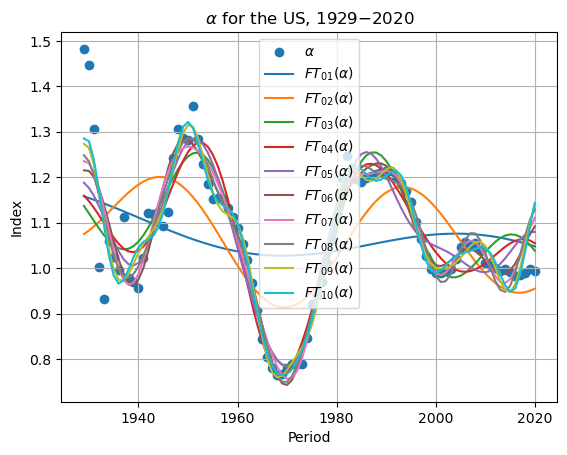

(92, 2)


In [6]:
_, x = collect_usa_investment_turnover()
plot_fourier_discrete(x)

In [9]:
# polynomial_features = PolynomialFeatures(degree=1)
# xp = polynomial_features.fit_transform(x.reset_index(level=0))

In [20]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
x = np.array(x.index.to_series()).reshape(-1, 1)
y = np.array(x).reshape(-1, 1)
lr.fit(x, y)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [19]:
lr.coef_[0][0]

0.9999999999999999

In [11]:
polynomial_features.summary()

AttributeError: 'PolynomialFeatures' object has no attribute 'summary'